# Introduction to vector databases on S&P 500 news

 # 📌 Objectives

 By the end of this notebook, students will be able to:

 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.

 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.

 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.

 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.

 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.

 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.

 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [ ]:
%pip install sentence-transformers
%pip install faiss-cpu

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive

import faiss
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/MNA/Fintech/Week 3/df_news.csv'

In [ ]:
df_news = pd.read_csv(file_path)
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:

### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.

### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 Implement the class with the following methods (functions):

 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).

 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.

You will test your class at the end.

### Step 1:
combine TITLE and SUMMARY into a single columna EMBEDDED_TEXT

In [ ]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' ' + df_news['SUMMARY']

### Step 2:
Load all-MiniLM-L6-v2 model

In [ ]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

### Step 3:
Define a custom vector store class

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

class CustomVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        assert len(documents) == len(metadata), "The number of documents MUST match the number of metadata."
        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = self.embedding_model.encode(documents, convert_to_tensor=True)

    def search(self, query, k=5, metadata_filter=None):
        # Filter documents and metadata if a filter is given
        if metadata_filter:
            filtered = [(doc, meta, emb) for doc, meta, emb in zip(self.documents, self.metadata, self.embeddings) if metadata_filter(meta)]
            if not filtered:
                return []
            # assign filtered results
            docs, metas, embs = zip(*filtered)
        else:
            # if a filter is not provided:
            docs, metas, embs = self.documents, self.metadata, self.embeddings
        # generate query embeddings
        query_embedding = self.embedding_model.encode([query], convert_to_tensor=True)
        # Calculates cosine similarity
        similarities = cosine_similarity(query_embedding, np.stack(embs))[0]

        # Get k most similar results
        top_indices = np.argsort(similarities)[::-1][:k]
        results = [(docs[i], metas[i], float(similarities[i])) for i in top_indices]
        return results



## Create and populate the vector store

 👉 **Instructions**:
 - Convert the combined EMBEDDED_TEXT column into a list of strings.
 - Create a metadata list of dictionaries for each document with keys:
   - 'PUBLICATION_DATE'
   - 'TICKER'
   - 'PROVIDER'
 - Instantiate your CustomVectorStore using:
   - The embedding model.
   - The list of document strings.
   - The metadata list.

 After initializing the store, you should be able to perform searches using:
'store.search("Apple earnings", k=3)'


### **Create and populate the vector store: code section**


### Convert the combined EMBEDDED_TEXT column into a list of strings.

In [ ]:
documents = df_news['EMBEDDED_TEXT'].tolist()

### Create a metadata list of dictionaries for each document with keys:

* 'PUBLICATION_DATE'
* 'TICKER'
* 'PROVIDER'

In [ ]:
# creating a metadata list of dictionaries using a comprehensive list
metadata = [
    {
        'PUBLICATION_DATE': row['PUBLICATION_DATE'],
        'TICKER': row['TICKER'],
        'PROVIDER': row['PROVIDER']
    }
    for _, row in df_news.iterrows()
]

### Instantiate your CustomVectorStore using:

* The embedding model.
* The list of document strings.
* The metadata list.

In [ ]:
store = CustomVectorStore(embedding_model, documents, metadata)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


#### After initializing the store, you should be able to perform searches using: 'store.search("Apple earnings", k=3)'

## Using your vector store and analyzing the results

### Retrieve AI Announcements

 Now that your vector store is working, let's use it to retrieve relevant documents.

 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text


### **Using your vector store and analyzing the results: code section**

### Perform a semantic search using the query "AI announcement" with k=50 to retrieve the top 50 most relevant articles.

In [ ]:
results = store.search("AI announcement", k=50)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


### Display each result's:
* TICKER
*   PUBLICATION_DATE
* PROVIDER
* Similarity score
* Full document text

In [ ]:
for doc, meta, score in results:
    print(f"TICKER: {meta['TICKER']}")
    print(f"PUBLICATION_DATE: {meta['PUBLICATION_DATE']}")
    print(f"PROVIDER: {meta['PROVIDER']}")
    print(f"SIMILARITY SCORE: {score:.4f}")
    print(f"DOCUMENT TEXT: {doc}")
    print("-" * 80)

TICKER: ADBE
PUBLICATION_DATE: 2025-05-27
PROVIDER: Investor's Business Daily
SIMILARITY SCORE: 0.5567
DOCUMENT TEXT: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.
--------------------------------------------------------------------------------
TICKER: JKHY
PUBLICATION_DATE: 2025-03-17
PROVIDER: Insider Monkey
SIMILARITY SCORE: 0.5467
DOCUMENT TEXT: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]
--------------------------------------------------------------------------------
TICK

 ### **Q1.** What are the top companies (by TICKER) most frequently appearing in the top 50 search results for the query "AI announcement"?  
 Check their company names on Yahoo Finance. Are you surprised by the results?

 ✅ **Your task**:
 - Count the number of times each TICKER appears.
 - Print and analyze the top results.

**Q1 response:**



The results make sense if I look at the news summary, not all of them are big tech companies, but once I read the summary it all made sense.

Top companies by Ticker:

1. PLTR (6) Palantir Technologies Inc. | Software, Infra
2. BKR (4) Baker Hughes Company | Oil, Gas equipoment
3. CTSH (3) Cognizant Technology Solutions Corporation | IT services
4. AMD (3) Advanced Micro Devices, Inc. | Semiconductors
5. QCOM (2) QUALCOMM Incorporated | Semiconductors
6. EXPE (2) Expedia Group, Inc. | Travel services
7. INTC (2) Intel Corporation | Semiconductors
8. MSFT (2) Microsoft Corporation | Software, Infra
9. META (2) Meta Platforms, Inc. | Internet content
10. AMZN (2) Amazon.com, Inc. | Internet retail
11. ADBE (1) Adobe Inc. | Software
12. ORCL (1) Oracle corporation | Software, Infra
13. GOOGL (1) Alphabet Inc | Internet content, Information

I was curious about why Palantir had more results thatn Alphabet, for example, after reaserching on internet about the company, I found that:
Palantir is positioned as an AI industrial platform for governments and corporations, almost all its relases are AI related and they explicitely highlight that in their communications.

I also found that during may some companies celebrate events where they relaese news together to maximaze the impact.





### **Q2.** What is the date range of the top 50 results? Are the articles evenly distributed across time?

 ✅ **Your task**:
 - Extract the publication dates of the top 50 results.
 - Plot a histogram to visualize the temporal distribution.
 - Reflect: Are these mentions clustered in recent months or spread evenly?

 🧠 **Follow-up**: What could explain the timing of increased AI announcements?

**Q2 response:**

The date range of the top 50 list is May 13th, 2025 to May 31st, 2025

Relevant news related to AI announcements was heavily concentrated during the final three weeks of May, particularly in the last week. This surge in activity toward the end of the month may reflect a strategic effort by companies to increase shareholder confidence through high-profile disclosures and developments in artificial intelligence.

### Extract publication dates

In [ ]:
publication_dates = [result[1]['PUBLICATION_DATE'] for result in results]

### Plot temporal distribution

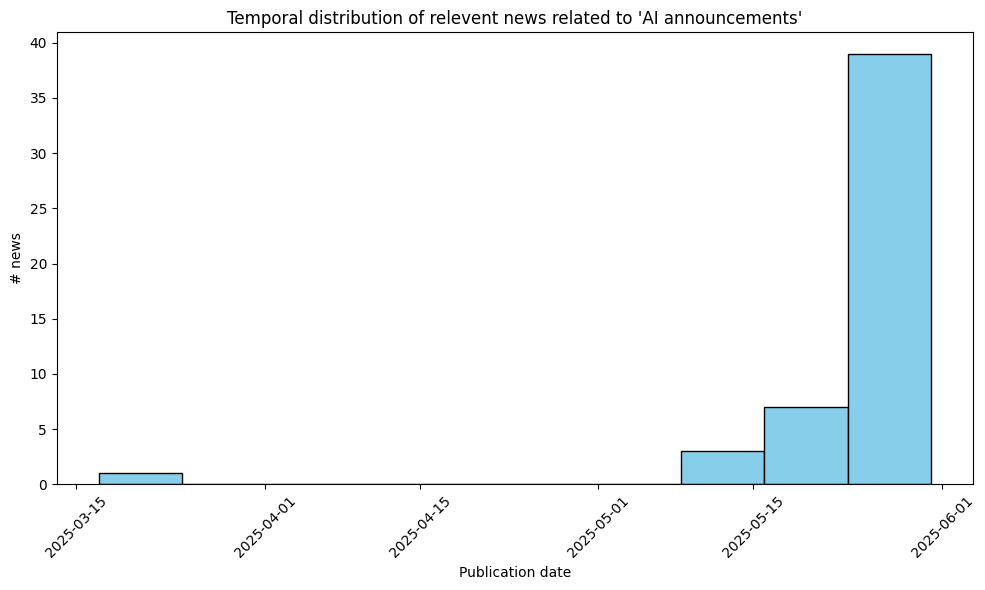

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(publication_dates, bins=10, color='skyblue', edgecolor='black')
plt.title("Temporal distribution of relevent news related to 'AI announcements'")
plt.xlabel("Publication date")
plt.ylabel("# news")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Implement FAISS vector store

 We’ll now implement a **FAISS-based vector store**, designed for efficient similarity search at scale.

 👉 **Steps**:
 - Use the same sentence transformer model: all-MiniLM-L6-v2.
 - Encode your text into embessings
 - Normalize the vectors.

 FAISS supports multiple similarity types. For cosine similarity, we must:

 ✅ Normalize vectors to unit length  
 ✅ Use `IndexFlatIP` (inner product), because:
 - For normalized vectors, inner product = cosine similarity


In [ ]:
document_embeddings = embedding_model.encode(documents, normalize_embeddings=True)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


We’ll now:
 - Initialize the FAISS index
 - Add the document embeddings

In [ ]:
dimension = document_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(dimension)

In [ ]:
faiss_index.add(document_embeddings)

### Create a `FaissVectorStore` class with a `.search()` method.

 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata

In [ ]:
class FaissVectorStore:
    def __init__(self, embedding_model, index, documents, metadata):
        self.embedding_model = embedding_model
        self.index = index
        self.documents = documents
        self.metadata = metadata

    def search(self, query, k=5, metadata_filter=None):
        # Normalize query
        query_embedding = self.embedding_model.encode([query], normalize_embeddings=True)

        # Apply metadata filter if provided
        if metadata_filter:
            # filter based on the metadata filter provided
            filtered = [(i, meta) for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered:
                return []
            indices, metas = zip(*filtered)
            # reconstruct embeddings
            filtered_embeddings = np.array([self.index.reconstruct(i) for i in indices])
            # create a new temp index using IP as similarity metric
            temp_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
            # add filtered vectors to the temp_index
            temp_index.add(filtered_embeddings)
            # perform search on the temp index
            scores, result_indices = temp_index.search(query_embedding, k)
            # get final indices
            final_indices = [indices[i] for i in result_indices[0]]
        else:
            # if no filter is provided:
            scores, result_indices = self.index.search(query_embedding, k)
            final_indices = result_indices[0]

        # Build results
        results = [
            (self.documents[i], self.metadata[i], float(scores[0][j]))
            for j, i in enumerate(final_indices)
        ]
        return results

 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`

 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text

In [ ]:
faiss_store = FaissVectorStore(embedding_model, faiss_index, documents, metadata)

In [ ]:
faiss_results = faiss_store.search("AI announcement", k=50)

In [ ]:
for doc, meta, score in faiss_results:
    print(f"TICKER: {meta['TICKER']}")
    print(f"PUBLICATION_DATE: {meta['PUBLICATION_DATE']}")
    print(f"PROVIDER: {meta['PROVIDER']}")
    print(f"COSINE SIMILARITY SCORE: {score:.4f}")
    print(f"DOCUMENT TEXT: {doc}")
    print("-" * 80)

TICKER: ADBE
PUBLICATION_DATE: 2025-05-27
PROVIDER: Investor's Business Daily
COSINE SIMILARITY SCORE: 0.5567
DOCUMENT TEXT: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.
--------------------------------------------------------------------------------
TICKER: JKHY
PUBLICATION_DATE: 2025-03-17
PROVIDER: Insider Monkey
COSINE SIMILARITY SCORE: 0.5467
DOCUMENT TEXT: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]
-----------------------------------------------------------------------

## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:

 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [ ]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation',
    'Cryptocurrency'

]

In [ ]:
def display_results(query, results, store_type):
    print(f"\n--- {store_type} Results for Query: '{query}' ---")
    for i, (doc, meta, score) in enumerate(results, 1):
        print(f"Result {i}:")
        print(f"TICKER: {meta['TICKER']}")
        print(f"PUBLICATION_DATE: {meta['PUBLICATION_DATE']}")
        print(f"PROVIDER: {meta['PROVIDER']}")
        print(f"SIMILARITY SCORE: {score:.4f}")
        print(f"DOCUMENT TEXT: {doc}")
        print("-" * 60)

In [ ]:
for query in test_queries:
    custom_results = store.search(query, k=5)
    faiss_results = faiss_store.search(query, k=5)

    display_results(query, custom_results, "CustomVectorStore")
    display_results(query, faiss_results, "FaissVectorStore")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



--- CustomVectorStore Results for Query: 'Stock price drop' ---
Result 1:
TICKER: PKG
PUBLICATION_DATE: 2025-05-29
PROVIDER: StockStory
SIMILARITY SCORE: 0.5706
DOCUMENT TEXT: 3 Reasons to Avoid PKG and 1 Stock to Buy Instead Packaging Corporation of America has gotten torched over the last six months - since November 2024, its stock price has dropped 21.6% to $195 per share. This might have investors contemplating their next move.
------------------------------------------------------------
Result 2:
TICKER: HUM
PUBLICATION_DATE: 2025-05-27
PROVIDER: StockStory
SIMILARITY SCORE: 0.5700
DOCUMENT TEXT: 2 Reasons to Like HUM and 1 to Stay Skeptical Humana has gotten torched over the last six months - since November 2024, its stock price has dropped 24.3% to a new 52-week low of $224.50 per share. This may have investors wondering how to approach the situation.
------------------------------------------------------------
Result 3:
TICKER: CRL
PUBLICATION_DATE: 2025-05-21
PROVIDER: StockS

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

**Q3 response:**

* Stock price drop: Identical result
* Layoffs: Identical result
* Mergers and acquisitions: Identical result
* Fed interest rate: Identical result
* Regulation: Identical result
* Cryptocurrency: Identical result

All of the results are identical, this may occur because they share the embeddings model, and the similary search output must be the same. And the list of news is relatively small.

The embeddings model (all-MiniLM-L6-v2) is the same for both classes.

The embeddings model transform the text into a high-dimensional vector that caputes semantic meaning. If both stores use the same model, they'll generate a very similar vector representations.


## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:

 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [ ]:
model_mpnet = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
store_mini = CustomVectorStore(embedding_model, documents, metadata)
store_mpnet = CustomVectorStore(model_mpnet, documents, metadata)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
def compare_results(query, results_mini, results_mpnet):
    print(f"\n::: Query: '{query}' :::")
    print("\n-- Results from all-MiniLM-L6-v2 --")
    for i, (doc, meta, score) in enumerate(results_mini, 1):
        print(f"{i}. [{meta['TICKER']}] {meta['PUBLICATION_DATE']} | {meta['PROVIDER']} | Score: {score:.4f}")
        print(f"Text: {doc}\n")

    print("-- Results from all-mpnet-base-v2 --")
    for i, (doc, meta, score) in enumerate(results_mpnet, 1):
        print(f"{i}. [{meta['TICKER']}] {meta['PUBLICATION_DATE']} | {meta['PROVIDER']} | Score: {score:.4f}")
        print(f"Text: {doc}\n")

In [ ]:
for query in test_queries:
    results_mini = store_mini.search(query, k=5)
    results_mpnet = store_mpnet.search(query, k=5)
    compare_results(query, results_mini, results_mpnet)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



::: Query: 'Stock price drop' :::

-- Results from all-MiniLM-L6-v2 --
1. [PKG] 2025-05-29 | StockStory | Score: 0.5706
Text: 3 Reasons to Avoid PKG and 1 Stock to Buy Instead Packaging Corporation of America has gotten torched over the last six months - since November 2024, its stock price has dropped 21.6% to $195 per share. This might have investors contemplating their next move.

2. [HUM] 2025-05-27 | StockStory | Score: 0.5700
Text: 2 Reasons to Like HUM and 1 to Stay Skeptical Humana has gotten torched over the last six months - since November 2024, its stock price has dropped 24.3% to a new 52-week low of $224.50 per share. This may have investors wondering how to approach the situation.

3. [CRL] 2025-05-21 | StockStory | Score: 0.5533
Text: Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, What You Need To Know A number of stocks fell in the afternoon session after the major indices pulled back (Nasdaq -1.3%, S&P 500 - 1.4%) as

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



::: Query: 'Mergers and acquisitions' :::

-- Results from all-MiniLM-L6-v2 --
1. [KEY] 2025-05-31 | Motley Fool | Score: 0.5672
Text: 2 Large Regional Bank Stocks That Could Get Acquired During the Trump Administration Mergers and acquisitions (M&A) could pick up in the banking sector under the Trump administration, which plans to deregulate the sector.  Large regional banks could experience consolidation.  The large regional players need to scale if they want to compete with the likes of JPMorgan Chase and Bank of America.

2. [STE] 2025-05-21 | Zacks | Score: 0.4999
Text: AST Business Growth & Strategic Acquisitions Support STERIS Stock STE frequently engages in strategic acquisitions and joint ventures to optimize its portfolio of businesses.

3. [COF] 2025-05-27 | Zacks | Score: 0.4927
Text: COF Stock Tanks 5.9% Post Discover Merger: A Good Buying Opportunity? COF shares have dipped 5.9% since the Discover deal. Can loan growth, merger synergies and a solid balance sheet drive a 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



::: Query: 'Fed interest rate' :::

-- Results from all-MiniLM-L6-v2 --
1. [DOC] 2024-09-13 | Yahoo Finance Video | Score: 0.4224
Text: How the 10-year yield affects REITs Interest rate-sensitive REITs (Real Estate Investment Trusts) are set to benefit from the Federal Reserve's anticipated easing of monetary policy. Richard Anderson, Wedbush managing director of equity research for REITs, joins Catalysts to provide insights into this segment of the market. Anderson observes an "instant gratification" scenario unfolding in REITs, noting their quick recovery despite the weaker state of the 10-year Treasury yield (^TNX). He explains that "any kind of investment vehicle with an income component like the REITs" tends to thrive in a declining rate environment. However, he raises questions about the longer-term outlook, wondering, "What does a better rate environment, a normal sloping yield curve, do to people's attention of the fundamentals of commercial real estate?" describing this as "t

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



::: Query: 'Cryptocurrency' :::

-- Results from all-MiniLM-L6-v2 --
1. [PYPL] 2025-05-27 | Zacks | Score: 0.5571
Text: 3 Crypto-Centric Stocks in Focus as Bitcoin Resumes Its Rally Bitcoin hovers near $110K as crypto sentiment surges. V, PYPL, and CLSK emerge as top stock picks with rising earnings outlooks.

2. [COIN] 2025-05-28 | Investor's Business Daily | Score: 0.5036
Text: Cryptocurrency Prices And News: Bitcoin Hovers Near Record High, Miners Join Rally Cryptocurrency News:  Cryptocurrency prices have been mixed this week after bitcoin surged to a new record high on May 22.  Bitcoin traded around $107,500 on Wednesday, modestly retreating new peak of $111,970 on Thursday according to CoinMarketCap data.  LMAX analyst Joel Kruger recently told IBD that the fresh high could set the stage for a measured rally toward $145,000.

3. [COIN] 2025-05-28 | Barrons.com | Score: 0.4287
Text: Bitcoin Price Falls. Key Crypto Conference Fails to Lift Digital Coins. Bitcoin’s  price edged dow

### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

**Q4 response:**

**Initial Observations and Model Comparison**

Upon reviewing the results for the query "Stock price drop", my first impression is that both MiniLM and mpnet provided accurate outputs. However, MiniLM appears to have a more straightforward interpretation of the news content. For example, in the KR article from Zacks, the phrase “stock drops” is present, but the article itself lacks substantive detail. In contrast, mpnet results, though not always containing the exact keywords, tend to offer richer context, such as the UBER news piece that links the share price decline to fears over Tesla's robotaxi developments, adding relevant causality and investment commentary.

In the case of the "Layoffs" query, mpnet duplicated its first and second result, and the AVGO article seems only loosely related to the topic. Meanwhile, MiniLM performed significantly better, retrieving articles that strongly align with the theme. This may be attributed to the simplicity of the query itself, MiniLM’s less nuanced semantic processing resulted in clearer matches with minimal ambiguity, yielding stronger overall relevance than mpnet in this instance.

After a deep dive into "Mergers and acquisitions", I conclude that MiniLM exhibits lower semantic drift. While mpnet returns higher average scores, MiniLM is more direct in identifying core topics. Mpnet, by conducting more layered semantic analysis, may surface connections between themes and queries that are not explicitly stated, offering potentially deeper insights, even though with a greater risk of introducing noise. Notably, MiniLM tends to include the actual query terms within the retrieved texts, indicating a shallower analysis which, depending on the use case, may actually enhance clarity and precision.


## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?

**Q5 response:**

Vector normalization ensures that all vectors have the same length, which is very important when using cosine similarity, as this metric measures the angle between vectors, not their magnitude.

* In the case of CustomVectorStore, normalization is handled automatically by the cosine_similarity function from scikit-learn, eliminating the need for manual preprocessing.
* The FAISS implementation requires explicit normalization, as FAISS requires this step for cosine similarity to function properly. Both the document embeddings and the query vector must be normalized to ensure accurate similarity results.


### **Q6.**  What would happen if vectors were not normalized before indexing?

**Q6 response:**

In FAISS, using IndexFlatIP without normalization would result in similarity scores that are influenced by vector magnitudes, not just direction. This would distort the semantic similarity and lead to inaccurate search results.

In the custom store, cosine similarity would still work correctly because the function normalizes internally, but performance might be affected if embeddings are not preprocessed properly.


## 🧠 Critical Thinking / Design Choices


### **Q7.** Which implementation would you choose for a production-scale search system? Why?


**Q7 response:**

For a production-scale search system, I would choose FAISS. Here's why:

* Scalability: FAISS is optimized for large-scale similarity search and can handle millions of vectors efficiently.
* Speed: It uses optimized C++ backends and supports GPU acceleration.
* Flexibility: FAISS supports various indexing strategies (e.g.: IVF, HNSW) for faster approximate search.
* Memory efficiency: It can store compressed vectors and use quantization techniques.

The custom store is great for learning purposes and small datasets but lacks the performance and scalability features needed for production.


### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.

**Q8 response:**

**FAISS** will scale significantly better.

**CustomVectorStore** uses brute-force pairwise similarity calculations, which become computationally expensive and slow as the dataset grows.
**FAISS** is designed for high-dimensional vector search at scale. It can index millions of vectors efficiently using approximate nearest neighbor algorithms, reducing both memory usage and query time.
